# Conversion from JSON to XML

In [31]:
import json
import pandas as pd
import dicttoxml
import matplotlib.pyplot as plt
import numpy as np

First open the JSON as dict

In [32]:
with open('lod-data.json') as file:
    dict = json.load(file)

Convert from dict to xml as bytes

In [33]:
xmlBytes = dicttoxml.dicttoxml(dict)

Finaly write bytes to file

In [5]:
f = open("lod-data.xml", "wb")
f.write(xmlBytes)
f.close()

# Preparing data as DataFrame 

In [101]:
counter = 0
for key, value in dict.items():
    if not value['sparql'] and not value['full_download'] and not value['other_download'] and not value['example']:
        print(key)
        counter+=1
print("-------")
print( str(counter) + " sources do not contain any link")

opendatacommunities-transparency-impact-indicators-affordable-housing-starts
opendatacommunities-imd-rank-2010
Face Link
personal-homepages
opendatacommunities-transparency-impact-indicators-households-in-temporary-accommodation
opendatacommunities-impact-indicators-planning-applications-granted
opendatacommunities-households-2008
opendatacommunities-households-social-lettings-general-needs-lettings-prp-household-composition
instance-hub-fiscal-years
opendatascotland-simd-income-rank
Gastronomía Peruana
medicine
maurizio colcuc
-------
13 sources do not contain any link


Each data source contains at least one of the four attributes "sparql", "full_download", "other_download" or "example". 
Only 13 Sources exist, which do not contain none of those attributes. Since those sources do not contain any link at all, they are negligible.

First convert the data to pandas

In [34]:
pdData = pd.DataFrame.from_dict(dict).transpose()

Check the content of the "status" attributes: 

In [84]:
check = True
for x in pdData[pdData['sparql'].apply(lambda x : not not x)]['sparql']:
    check = check and "FAIL" in x[0]['status'] or "OK" in x[0]['status']
for x in pdData[pdData['full_download'].apply(lambda x : not not x)]['full_download']:
    check = check and "FAIL" in x[0]['status'] or "OK" in x[0]['status']
for x in pdData[pdData['other_download'].apply(lambda x : not not x)]['other_download']:
    check = check and "FAIL" in x[0]['status'] or "OK" in x[0]['status']
for x in pdData[pdData['example'].apply(lambda x : not not x)]['example']:
    check = check and "FAIL" in x[0]['status'] or "OK" in x[0]['status']
if check:
    print("Every status contains either 'OK' or 'FAIL'")
else:
    print("There exists a status not containing 'FAIL' nor 'OK'")

Every status contains either 'OK' or 'FAIL'


Knowing this, we can add more attributes to the data and create a summary:

In [65]:
def extendAttributes(pdData):
    pdData['sparql_alive'] = [ not ( not x or "FAIL" in x[0]['status']) for x in pdData['sparql'] ]
    pdData['full_download_alive'] = [ not ( not x or "FAIL" in x[0]['status']) for x in pdData['full_download'] ]
    pdData['other_download_alive'] = [ not ( not x or "FAIL" in x[0]['status']) for x in pdData['other_download'] ]
    pdData['example_alive'] = [ not ( not x or "FAIL" in x[0]['status']) for x in pdData['example']]
    pdData['alive'] = pdData.apply(lambda row: row['example_alive'] or row['other_download_alive'] or row['full_download_alive'] or row['sparql_alive'], axis=1)
    return pdData

def tripleStrToInt(x):
    if not x:
        return 0
    
    if isinstance(x, str):
        x = x.replace(',','')
        x = x.replace('.','')
        x = x.replace(' ','')
        x = x.replace('triples', '')
        # Next lines convert the following str '>1.3 million'
        x = x.replace('>', '')
        x = x.replace('million','000000')
    return int(x)

def createSummary(pdData):
    summary = pd.DataFrame()
    summary['sources_total'] =  [ len(pdData) ] 
    summary['sources_alive'] = [ len(pdData[pdData['alive']]) ]
    summary['sources_dead'] = [ summary['sources_total'] - summary['sources_alive'] ]
    
    summary['sparql_alive'] = [ len(pdData[pdData['sparql_alive']]) ] 
    summary['other_download_alive'] = [ len(pdData[pdData['other_download_alive']]) ]
    summary['example_alive'] = [ len(pdData[pdData['example_alive']]) ]
    summary['full_download_alive'] = [ len(pdData[pdData['full_download_alive']]) ]
    
    summary['sparql_exists'] = [ len(pdData[pdData['sparql'].apply(lambda x: not not x)]) ]
    summary['other_download_exists'] = [ len(pdData[pdData['other_download'].apply(lambda x: not not x)]) ]
    summary['example_exists'] = [ len(pdData[pdData['example'].apply(lambda x: not not x)]) ]
    summary['full_download_exists'] = [ len(pdData[pdData['full_download'].apply(lambda x: not not x)]) ]
    
    summary['triples_alive'] = pdData[pdData['alive']]['triples'].apply(lambda x: tripleStrToInt(x)).sum()
    summary['triples_total'] = pdData['triples'].apply(lambda x: tripleStrToInt(x)).sum()
    summary['triples_dead'] = summary['triples_total'] - summary['triples_alive'] 
    
    return summary


In [36]:
pdData = extendAttributes(pdData)
summary = createSummary(pdData)


# Analysis of the current data 

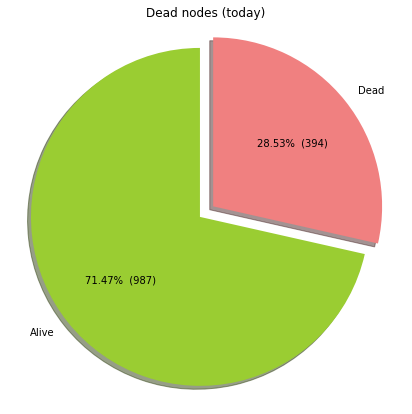

In [38]:
labels = 'Alive', 'Dead'
sizes = [summary['sources_alive'][0], summary['sources_dead'][0] ]
colors = ['yellowgreen', 'lightcoral', 'gold', 'lightskyblue']
explode = (0.1, 0) 

def make_autopct(values):
    def my_autopct(pct):
        val = int(round(pct* summary['sources_total']/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes, explode=explode, labels=labels, 
        shadow=True, startangle=90, colors=colors, autopct=make_autopct(sizes))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Dead nodes (today)')
plt.show()

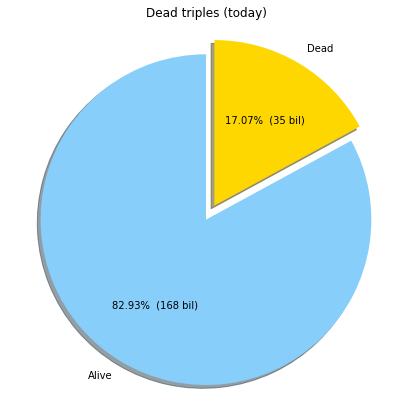

In [39]:
labels = 'Alive', 'Dead'
sizes = [summary['triples_alive'][0], summary['triples_dead'][0] ]
colors = ['lightskyblue', 'gold' ]
explode = (0.1, 0) 

fig1, ax1 = plt.subplots(figsize=(7,7))
def make_autopct(values):
    def my_autopct(pct):
        val = int(round(pct* summary['triples_total']/100000000000.0))
        return '{p:.2f}%  ({v:d} bil)'.format(p=pct,v=val)
    return my_autopct

ax1.pie(sizes, explode=explode, labels=labels,
        shadow=True, startangle=90, colors=colors, autopct=make_autopct(sizes))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Dead triples (today)')
plt.show()

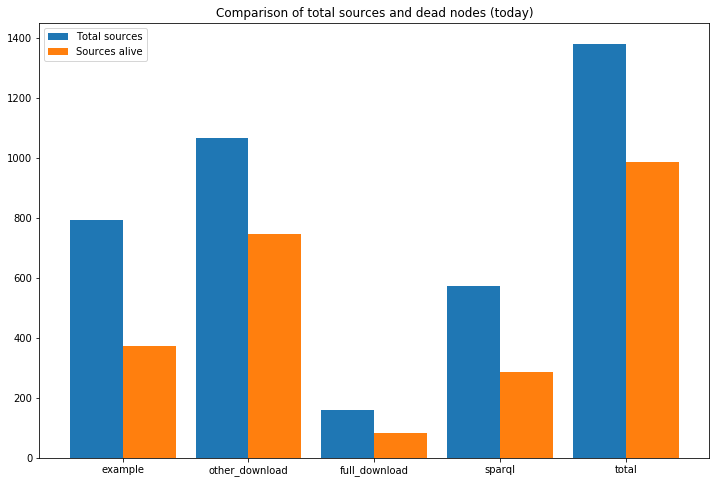

In [40]:
N = 5
sources_total = (summary['example_exists'][0], summary['other_download_exists'][0], summary['full_download_exists'][0], summary['sparql_exists'][0], summary['sources_total'][0])
sources_alive = (summary['example_alive'][0], summary['other_download_alive'][0], summary['full_download_alive'][0], summary['sparql_alive'][0], summary['sources_alive'][0])

ind = np.arange(N) 
width = 0.42

fig1, ax1 = plt.subplots(figsize=(12,8))

ax1.bar(ind, sources_total, width, label='Total sources')
ax1.bar(ind + width, sources_alive, width, label='Sources alive')

plt.ylabel('')
plt.title('Comparison of total sources and dead nodes (today)')

plt.xticks(ind + width / 2, ('example', 'other_download', 'full_download', 'sparql', 'total'))
plt.legend(loc='best')
plt.show()

# Comparison by domain


In [48]:
domainSummary = pdData.groupby(['domain']).sum()
domainSummary['total_nodes'] = pdData.groupby(['domain']).count()['_id']

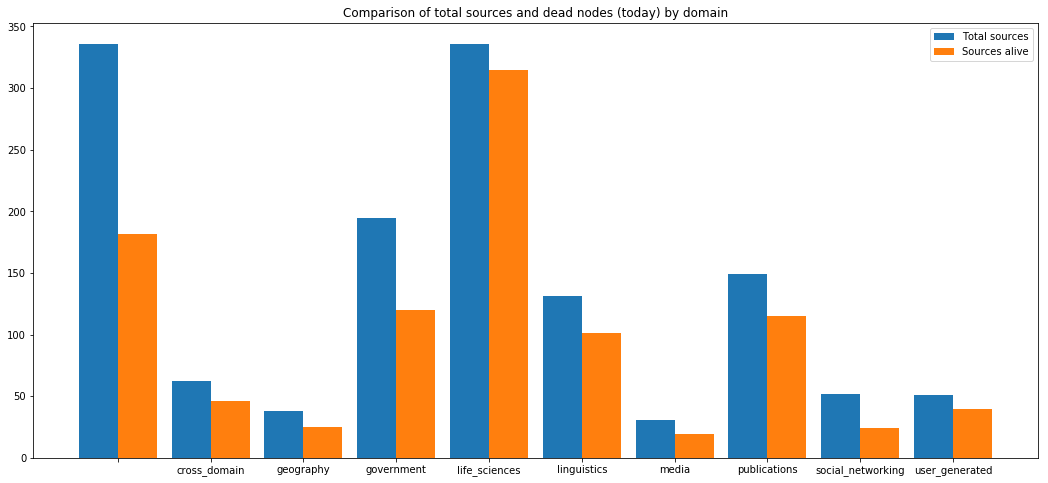

In [66]:
N = 10
sources_total = domainSummary['total_nodes'].tolist()
sources_alive = domainSummary['alive'].tolist()
ind = np.arange(N) 
width = 0.42

fig1, ax1 = plt.subplots(figsize=(18,8))

ax1.bar(ind, sources_total, width, label='Total sources')
ax1.bar(ind + width, sources_alive, width, label='Sources alive')

plt.ylabel('')
plt.title('Comparison of total sources and dead nodes (today) by domain')

plt.xticks(ind + width / 2, domainSummary.index.tolist())
plt.legend(loc='best')
plt.show()

# Comparison with old values
For the LOD cloud there exist old data, sadly the total data is missing for 2018-06-28 until today(it exists only split by domain). From 2017-08-22 the data is also missing, since it only exist as image files.
This means for now we only got data for the following dates:
 - 2017-08-22 (does not contain information if the nodes are dead)
 - 2018-04-30 (does not contain information if the nodes are dead)
 - 2018-05-30
 - 2018-06-28
 - today (2019-04)

First compare the data with the latest data (2018-06-28)

In [41]:
with open('lod-data/json/lod-data_2018-28-06.json') as file:
    dict_20180628 = json.load(file)
with open('lod-data/json/lod-data_2018-30-05.json') as file:
    dict_20180530 = json.load(file)
with open('lod-data/json/lod-data_2018-30-04.json') as file:
    dict_20180430 = json.load(file)
    
pdData_20180628 = pd.DataFrame.from_dict(dict_20180628).transpose()
pdData_20180628 = extendAttributes(pdData_20180628)
summary_20180628 = createSummary(pdData_20180628)

pdData_20180530 = pd.DataFrame.from_dict(dict_20180530).transpose()
pdData_20180530 = extendAttributes(pdData_20180530)
summary_20180530 = createSummary(pdData_20180530)


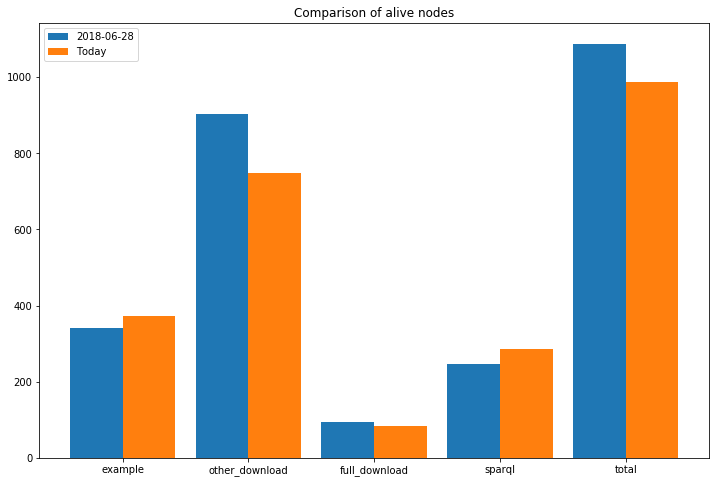

In [46]:
N = 5
sources_alive_today = (summary['example_alive'][0], summary['other_download_alive'][0], summary['full_download_alive'][0], summary['sparql_alive'][0], summary['sources_alive'][0])
sources_alive_20180628 = (summary_20180628['example_alive'][0], summary_20180628['other_download_alive'][0], summary_20180628['full_download_alive'][0], summary_20180628['sparql_alive'][0], summary_20180628['sources_alive'][0])

ind = np.arange(N) 
width = 0.42

fig1, ax1 = plt.subplots(figsize=(12,8))

ax1.bar(ind, sources_alive_20180628, width, label='2018-06-28')
ax1.bar(ind + width, sources_alive_today, width, label='Today')

plt.ylabel('')
plt.title('Comparison of alive nodes')

plt.xticks(ind + width / 2, ('example', 'other_download', 'full_download', 'sparql', 'total'))
plt.legend(loc='best')
plt.show()

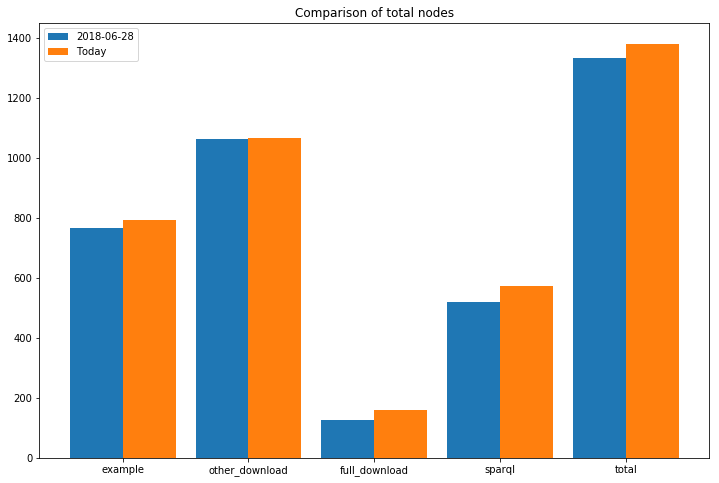

In [24]:
N = 5
sources_today = (summary['example_exists'][0], summary['other_download_exists'][0], summary['full_download_exists'][0], summary['sparql_exists'][0], summary['sources_total'][0])
sources_20182806 = (summary_20182806['example_exists'][0], summary_20182806['other_download_exists'][0], summary_20182806['full_download_exists'][0], summary_20182806['sparql_exists'][0], summary_20182806['sources_total'][0])

ind = np.arange(N) 
width = 0.42

fig1, ax1 = plt.subplots(figsize=(12,8))

ax1.bar(ind, sources_20182806, width, label='2018-06-28')
ax1.bar(ind + width, sources_today, width, label='Today')

plt.ylabel('')
plt.title('Comparison of total nodes')

plt.xticks(ind + width / 2, ('example', 'other_download', 'full_download', 'sparql', 'total'))
plt.legend(loc='best')
plt.show()